_Aurélien Pion_

In [139]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from mixture import gaussian_mixture
from numba import jit

In [4]:
SEED = 0

In [153]:
import time, sys

# utility function fr progress bar 
# see https://stackoverflow.com/questions/3160699/python-progress-bar for more details
def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1:.2f}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [5]:
class Graph:
    """encode a graph
    
    Parameters:
    ...
    """
    def __init__(self, sizes, p, seed=0):
        self.order = np.sum(np.array([size for size in sizes]))
        self.sizes = sizes
        self.node = None
        self.adjacency_matrix = None
        self.p = p
        self.seed = seed
        
    def generate_graph(self):
        self.node = nx.stochastic_block_model(self.sizes, self.p, seed=self.seed)
        self.adjacency_matrix = nx.adjacency_matrix(self.node).todense()

class GraphSet:
    """set of graphs
    """
    
    def __init__(self, partitions, probas, T, S, seed=0):
        self.partitions = partitions
        self.probas = probas
        self.seed = seed
        self.graphs = []
        self.T = T
        self.S = S
        
    def generate_graphs(self):
        for t in range(self.T):
            for s in range(self.S):
                graph = Graph(self.partitions[t], self.probas[t])
                graph.generate_graph()
                self.graphs.append(graph)

In [6]:
partitions = [[30, 20], [10, 23]]
probas = [[[0.67, 0.1], [0.1, 0.6]], [[0.39, 0.01], [0.01, 0.76]]]
graph_set = GraphSet(partitions, probas, 2, 3)
graph_set.generate_graphs()

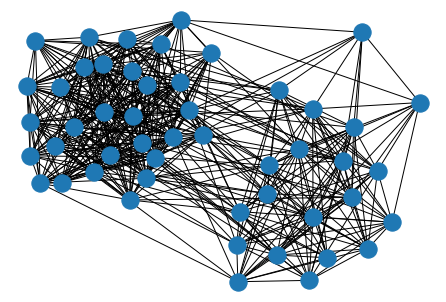

In [7]:
nx.draw(graph_set.graphs[0].node)

In [8]:
a = np.array([1]*4)
a.reshape(2,2)
a

array([1, 1, 1, 1])

In [9]:
def sample_minibatch(Graphs, B):
    sample = random.sample(range(Graphs.T+Graphs.S), B)
    return [Graphs.graphs[s] for s in sample]



#def step_size(gammma_0, gradient, kwargs**)

C = np.array([[0,1, 0], [1,0, 0], [0,0,0]])
C_bar = np.array([[0,1, 1], [0,1, 1], [1,1,0]])
T = np.array([[0.2,.3,.9], [1.1,2.4,1.4], [1.6,1.4,1.9]])


In [439]:
class CG_solver:
    """cg solver
    """
    def __init__(self, T_0, C, C_bar, h, D):
        self.T = T_0
        self.C = C
        self.C_bar = C_bar
        self.N, self.K = C.shape
        self.h = h
        self.D = D
        
    @jit(forceobj = True)
    def L(self, C_1, C_2, T):
        """
        compute the matrix [[(C_ij - C_bar_11)...]... [...(C_ij - C_bar_kl)...]...]
        -> fix if and compute for all C_bar_kl
        """
        one = np.array([1 for i in range(len(C_1))])

        h_bar = T.T@one
        constC_1 = np.dot(np.dot(np.square(C_1), self.h.reshape(-1, 1)),
                     np.ones(len(C_2)).reshape(1, -1))
        constC_2 = np.dot(np.ones(len(C_1)).reshape(-1, 1),
                     np.dot(h_bar.reshape(1, -1), np.square(C_2).T))
        L = -np.dot(C_1, T).dot(C_2.T)
        return L + constC_1 + constC_2
        #tens = constC + A
        # tens -= tens.min()
        #return tens
        #return np.square(np.array([self.C[i][j]]*self.N*self.K) - self.C_bar.reshape(self.N*self.K))
    
    def gradient(self, T):
        #G = [0 for i in range(self.N*self.K)]
        #for i in range(self.N):
        #    for j in range(self.K):
        #        G[i+self.N*j] = np.sum(self.L(i, j)*T.reshape(self.N*self.K))
        #return 2*np.array(G).reshape(self.N,self.K)
        return self.L(self.C, self.C_bar, self.T) + self.L(self.C.T, self.C_bar.T, self.T)
    
    @jit(forceobj = True)
    def direction(self, G):
        """G symmetric !!!!
        """
        n, k = G.shape
        A_sum = np.zeros((k, k))
        A_sum[:][0] = np.array([1 for i in range(k)]) 
        b_eq = np.array([0 for i in range(k)])
        b_eq[0] = 1
        X = []
        for i in range(n):
            x_i = linprog(G[i] + self.D[i], A_ub=-np.eye(k), b_ub=np.array([0 for i in range(k)]), A_eq = A_sum, b_eq = b_eq).x
            X.append(self.h[i]*x_i)
        return np.array(X)
        #return np.array([g_i/np.linalg.norm(g_i) for g_i in G])

    @jit(forceobj = True)
    def optimal_step(self, X):
        """return gamma
        """
        b = np.trace(self.L(self.C, self.C_bar, X-self.T).T@self.T + self.L(self.C, self.C_bar, self.T).T@(X-self.T) + self.D.T@(X-self.T))
        a = np.trace(self.L(self.C, self.C_bar, X-self.T).T@(X-self.T))
        gamma = 0.01
        if a > 0:
            gamma = min(1, max(0.01, -b/(2*a)))
        else:
            if a+b < 0:
                gamma = 1
        return gamma
    
    def run(self, epsilon):
        T_0 = 1000*self.T
        Max_ITER = 1000
        iter_n = 0
        old_loss = 0
        curr_loss = np.sum(self.L(self.C, self.C_bar, self.T) * self.T)
        crit = 1
        while crit > epsilon**2 and iter_n < Max_ITER:
            old_loss = curr_loss
            update_progress(iter_n/Max_ITER)
            T_0 = self.T
            G = self.gradient(self.T)
            #print(G)
            X = self.direction(G)
            gamma = self.optimal_step(X)
            self.T = (1-gamma)*self.T + gamma*X
            #print(self.T)
            iter_n += 1
            #print("gamma = ", gamma)
            curr_loss = np.sum(self.L(self.C, self.C_bar, self.T) * self.T)
            crit = np.abs(curr_loss - old_loss)/np.abs(old_loss)
        return self.T

        
    
C = np.array([[0,1, 1], [1,0, 0], [1,0,0]])
C_bar = np.array([[1, 0], [0, 1]])
#D = np.ones((3,3))
D = np.zeros((3,2))
T = np.array([[1/3,0], [1/4,0], [0,5/12]])
h = np.array([1/3, 1/4, 5/12])
solver = CG_solver(T, C, C_bar, h, D)
T = solver.run(0.001)
one_3 = np.array([1 for i in range(3)])

one_2 = np.array([1 for i in range(2)])
print(T)

print(T@one_2)
print(T.T@one_3)

Percent: [##--------] 21.30% [[0.16768657 0.16564676]
 [0.14261268 0.10738732]
 [0.18919018 0.22747649]]
[0.33333333 0.25       0.41666667]
[0.49948943 0.50051057]


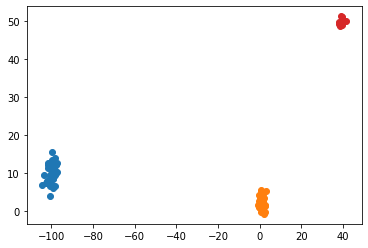

In [257]:
m = 3
n = 100
alpha = [0.5, 0.4, 0.01, 0.09]
d = 2
mu = [[-100, 10], [1, 2], [10, 30], [40, 50]]
sigma = [np.array([[3, 1], [1, 10]]), np.array([[1, 1], [0, 2]]), np.array([[3, 0], [0, 1]]), np.array([[1, 0], [0, 1]])]
X = gaussian_mixture(n, d, alpha, mu, sigma, True)

x = [[] for i in range(len(alpha))]
y = [[] for i in range(len(alpha))]
for z in X:
    x[z[1]].append(z[0][0])
    y[z[1]].append(z[0][1])

for i in range(len(alpha)):
    plt.plot(x[i], y[i], 'o')
plt.show()

Alpha 
Percent: [##########] 97.50% Alpha 1
Percent: [##########] 97.50% Alpha 2
Percent: [##########] 97.50% 

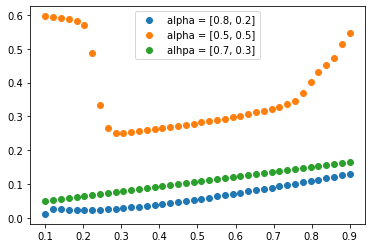

In [402]:
def matrix_neighboor(X, K):
    n = len(X)
    C = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i != j:
                C[i][j] = np.linalg.norm(X[i] - X[j])
                C[j][i] = np.linalg.norm(X[i] - X[j])
    res = np.zeros((n,n))
    for i in range(n):
        mini = np.inf
        j_mini = 0
        for j in range(n):
            if i!=j and C[i][j] < mini:
                mini = C[i][j]
                j_mini = j
        for j in range(n):
            if C[i][j] < 5*mini and i!=j:
                res[i][j] = C[i][j]
        #sorted_i = sorted(range(len(C[i])), key=lambda k:  C[i][k])
        #for k in range(K):
        #    if sorted_i[k] != i:
        #        res[i][sorted_i[k]] = C[i][sorted_i[k]]
    return res

m = 2
n = 40
alpha = [0.8, 0.2]
alpha_1 = [0.5, 0.5]
alpha_2 = [0.7, 0.3]#, 0.01]
d = 2
mu = [[-10, 10], [1, 2]]#, [10, 3]]#, [40, 50]]
sigma = [np.array([[3, 1], [1, 10]]), np.array([[1, 1], [0, 2]])]#, np.array([[3, 0], [0, 1]])]#, np.array([[1, 0], [0, 1]])]
X = gaussian_mixture(n, d, alpha, mu, sigma)
X_1 = gaussian_mixture(n, d, alpha_1, mu, sigma)
X_2 = gaussian_mixture(n, d, alpha_2, mu, sigma)
C = matrix_neighboor(X, 320)
C_1 = matrix_neighboor(X_1, 320)
C_2 = matrix_neighboor(X_2, 320)
#print("C = ", C)
C_bar = np.eye(m)
#print(C_bar)
#C_bar[0][0] = 0
#C_bar[1][1] = 0
#C_bar[2][2] = 0
#C_bar = np.eye(n)
#C_bar = C
D = np.zeros((n,m))
T = np.zeros((n,m))

a = 5
L = 40
B = np.linspace(0.1, 0.9, L)
dist = []

# alpha
print("Alpha ")
u = 0
for b in B:
    update_progress(u/L)
    u += 1
    h = [0 for i in range(n)]
    for i in range(n):
        res = 0
        for j in range(n):
            if C[i][j] != 0:
                res += 1
        h[i] = np.power(res + a, b)
    h = np.array(h)
    h = 1/np.sum(h)*h
    #h = np.array([np.power(np.sum(C[i]) + a, b) for i in range(n)])
    #h = 1/np.sum(h)*h
    for i in range(n):
        T[i][0] = h[i]

    solver = CG_solver(T, C, C_bar, h, D)
    T = solver.run(10e-3)
    one = np.array([1 for i in range(n)])
    one_3 = np.array([1 for i in range(m)])
    #print(np.sum(T.T@one))
    #print(T.T@one)
    dist.append(np.linalg.norm(T.T@one - np.array([alpha])))
print("Alpha 1")
dist_1 = []
# alpha 1
u = 0
for b in B:
    update_progress(u/L)
    u += 1
    h = [0 for i in range(n)]
    for i in range(n):
        res = 0
        for j in range(n):
            if C_1[i][j] != 0:
                res += 1
        h[i] = np.power(res + a, b)
    h = np.array(h)
    h = 1/np.sum(h)*h
    #h = np.array([np.power(np.sum(C[i]) + a, b) for i in range(n)])
    #h = 1/np.sum(h)*h
    for i in range(n):
        T[i][0] = h[i]

    solver = CG_solver(T, C_1, C_bar, h, D)
    T = solver.run(10e-3)
    one = np.array([1 for i in range(n)])
    one_3 = np.array([1 for i in range(m)])
    #print(np.sum(T.T@one))
    #print(T.T@one)
    dist_1.append(np.linalg.norm(T.T@one - np.array([alpha_1])))
print("Alpha 2")
dist_2 = []
# alpha 2
u = 0
for b in B:
    update_progress(u/L)
    u += 1
    h = [0 for i in range(n)]
    for i in range(n):
        res = 0
        for j in range(n):
            if C_2[i][j] != 0:
                res += 1
        h[i] = np.power(res + a, b)
    h = np.array(h)
    h = 1/np.sum(h)*h
    #h = np.array([np.power(np.sum(C[i]) + a, b) for i in range(n)])
    #h = 1/np.sum(h)*h
    for i in range(n):
        T[i][0] = h[i]

    solver = CG_solver(T, C_2, C_bar, h, D)
    T = solver.run(10e-3)
    one = np.array([1 for i in range(n)])
    one_3 = np.array([1 for i in range(m)])
    #print(np.sum(T.T@one))
    #print(T.T@one)
    dist_2.append(np.linalg.norm(T.T@one - np.array([alpha_2])))
plt.plot(B, dist, "o", label='alpha = [0.8, 0.2]')
plt.plot(B, dist_1, "o", label= "alpha = [0.5, 0.5]")
plt.plot(B, dist_2, "o", label="alhpa = [0.7, 0.3]")
plt.legend()
plt.show()

In [415]:
m = 3
n = 30
alpha = [0.5, 0.3, 0.2]
alpha_1 = [0.5, 0.5]
alpha_2 = [0.7, 0.3]#, 0.01]
d = 2
mu = [[-10, 10], [1, 2], [10, 3]]#, [40, 50]]
sigma = [np.array([[3, 1], [1, 10]]), np.array([[1, 1], [0, 2]]), np.array([[3, 0], [0, 1]])]#, np.array([[1, 0], [0, 1]])]
X = gaussian_mixture(n, d, alpha, mu, sigma)
X_1 = gaussian_mixture(n, d, alpha_1, mu, sigma)
X_2 = gaussian_mixture(n, d, alpha_2, mu, sigma)
C = matrix_neighboor(X, 320)

C_bar = np.eye(m)
#print(C_bar)
#C_bar[0][0] = 0
#C_bar[1][1] = 0
#C_bar[2][2] = 0
#C_bar = np.eye(n)
#C_bar = C
D = np.zeros((n,m))
T = np.zeros((n,m))

a = 5
L = 40
B = np.linspace(0.1, 0.9, L)
dist = []

# alpha
print("Alpha ")
u = 0
for b in B:
    update_progress(u/L)
    u += 1
    h = [0 for i in range(n)]
    for i in range(n):
        res = 0
        for j in range(n):
            if C[i][j] != 0:
                res += 1
        h[i] = np.power(res + a, b)
    h = np.array(h)
    h = 1/np.sum(h)*h
    #h = np.array([np.power(np.sum(C[i]) + a, b) for i in range(n)])
    #h = 1/np.sum(h)*h
    for i in range(n):
        T[i][0] = h[i]

    solver = CG_solver(T, C, C_bar, h, D)
    T = solver.run(10e-3)
    one = np.array([1 for i in range(n)])
    one_3 = np.array([1 for i in range(m)])
    #print(np.sum(T.T@one))
    print(T.T@one)
    dist.append(np.linalg.norm(T.T@one - np.array([alpha])))

solver = CG_solver(T, C, C_bar, h, D)
T = solver.run(10e-3)
one = np.array([1 for i in range(n)])
one_3 = np.array([1 for i in range(m)])
#print(np.sum(T.T@one))
#print(T.T@one)
plt.plot(B, dist, "o", label='alpha = [0.5, 0.3, 0.2]')


Alpha 
Percent: [----------] 0.00% [0.66207801 0.168961   0.168961  ]
Percent: [----------] 2.50% 

KeyboardInterrupt: 

In [414]:
print(T)

[[3.45884085e-02 1.71436824e-02 1.71436824e-02]
 [3.42939511e-02 4.31450898e-11 4.31450898e-11]
 [3.56346547e-02 8.52634372e-14 8.52634372e-14]
 [3.39832379e-02 3.83059401e-11 3.83059401e-11]
 [3.36541923e-02 5.18756416e-11 5.18756416e-11]
 [3.11002998e-02 1.56724912e-02 1.56724912e-02]
 [3.20945561e-02 1.60976593e-02 1.60976593e-02]
 [3.45884085e-02 1.71263842e-02 1.71263842e-02]
 [3.53903062e-02 6.82161657e-14 6.82161657e-14]
 [3.45884085e-02 2.34711426e-11 2.34711426e-11]
 [3.05201191e-02 6.53430876e-12 6.53430876e-12]
 [3.48683456e-02 1.09004972e-13 1.09004972e-13]
 [3.51352281e-02 3.25054362e-14 3.25054362e-14]
 [3.20945561e-02 1.60976593e-02 1.60976593e-02]
 [3.29304722e-02 1.64536017e-02 1.64536017e-02]
 [3.53903062e-02 1.85224638e-13 1.85224638e-13]
 [3.53903062e-02 1.65351451e-02 1.65351451e-02]
 [3.16212034e-02 1.58954903e-02 1.58954903e-02]
 [3.42939511e-02 4.52835332e-11 4.52835332e-11]
 [3.25288569e-02 1.62827593e-02 1.62827593e-02]
 [3.16212034e-02 8.03741454e-06 8.037414

[0.33, 0.33, 0.33]
[0.23255814 0.34883721 0.41860465]
Percent: [#---------] 13.20% [0.84745748 0.10731933 0.04522319]
[0.5, 0.3, 0.2]
[0.23255814 0.34883721 0.41860465]
Percent: [###-------] 28.10% [0.60576438 0.10724502 0.28964817]
[0.7, 0.29, 0.01]
[0.23255814 0.34883721 0.41860465]
Percent: [####------] 41.30% [0.56154414 0.00712171 0.43585107]
[0.2, 0.4, 0.4]
[0.23255814 0.34883721 0.41860465]
Percent: [####------] 44.10% [0.46320004 0.11706251 0.42486718]


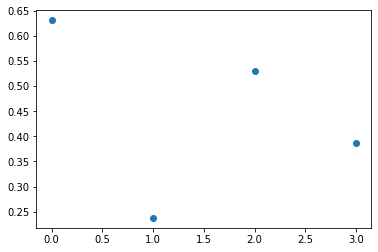

In [544]:
m = 3
n = 20
alpha = [0.33, 0.33, 0.33]
alpha_1 = [0.5, 0.5]
alpha_2 = [0.7, 0.3]#, 0.01]
d = 2
mu = [[-10, 10], [1, 2], [10, 3]]#, [40, 50]]
sigma = [np.array([[3, 1], [1, 10]]), np.array([[1, 1], [0, 2]]), np.array([[3, 0], [0, 1]])]#, np.array([[1, 0], [0, 1]])]
X = gaussian_mixture(n, d, alpha, mu, sigma)
X_1 = gaussian_mixture(n, d, alpha_1, mu, sigma)
X_2 = gaussian_mixture(n, d, alpha_2, mu, sigma)
C = matrix_neighboor(X, 320)

C_bar = np.eye(m)
#print(C_bar)
#C_bar[0][0] = 0
#C_bar[1][1] = 0
#C_bar[2][2] = 0
#C_bar = np.eye(n)
#C_bar = C
D = np.zeros((n,m))
T = np.zeros((n,m))

a = 5
L = 40
b = .2
B = np.linspace(0.1, 0.5, 10)
dist = []
alpha_h_bar = []
alpha_0 = [0.33, 0.33, 0.33]
alpha_1 = [0.5, 0.3, 0.2]
alpha_2 = [0.7, 0.29, 0.01]
alpha_3 = [0.2, 0.4, 0.4]
Alpha = [alpha_0, alpha_1, alpha_2, alpha_3]
for b in B:
    for alpha in Alpha:
        print(alpha)
        mu = [[-10, 10], [1, 2], [10, 3]]#, [40, 50]]
        sigma = [np.array([[3, 1], [1, 10]]), np.array([[1, 1], [0, 2]]), np.array([[3, 0], [0, 1]])]#, np.array([[1, 0], [0, 1]])]
        X = gaussian_mixture(n, d, alpha, mu, sigma)
        C = matrix_neighboor(X, 320)
        h = [0 for i in range(n)]
        for i in range(n):
            res = 0
            for j in range(n):
                if C[i][j] != 0:
                    res += 1
            h[i] = np.power(res + a, b)
        h = np.array(h)
        h = 1/np.sum(h)*h
        h = np.array([1/n for i in range(n)])
        #h = np.array([np.power(np.sum(C[i]) + a, b) for i in range(n)])
        #h = 1/np.sum(h)*h
        h_bar_0 = np.array([(i+1)/(i+m) for i in range(m)])
        #print(h_bar_0)
        h_bar_0 = 1/np.sum(h_bar_0)*h_bar_0
        print(h_bar_0)
        #T = h[: ,None]*h_bar_0[None,:]
        #print(T.T@one)
        for i in range(n):
            T[i][0] = h[i]*0.7
            T[i][1] = h[i]*0.3

        solver = CG_solver(T, C, C_bar, h, D)
        T = solver.run(10e-3)
        one = np.array([1 for i in range(n)])
        one_3 = np.array([1 for i in range(m)])
        #print(np.sum(T.T@one))
        print(T.T@one)
        #print(T)
        alpha_h_bar.append(T.T@one)
        dist.append(np.linalg.norm(T.T@one - np.array([alpha])))
    plt.plot([i for i in range(4)], dist, "o", label='alpha = [0.8, 0.02, 0.18]')
#solver = CG_solver(T, C, C_bar, h, D)
#T = solver.run(10e-3)
#one = np.array([1 for i in range(n)])
#one_3 = np.array([1 for i in range(m)])
#print(np.sum(T.T@one))
#print(T.T@one)


In [543]:
print(alpha_h_bar)

[array([9.09278669e-01, 9.07213309e-02, 9.23128508e-11]), array([0.7       , 0.11756395, 0.18243605]), array([0.961776  , 0.038224  , 0.02324479]), array([0.91458767, 0.08541233, 0.00661797])]


In [524]:
print(T.T@one)

[0.36304296 0.32387516 0.32245884]


In [487]:
res = []
for i in range(n):
    maxi = 0
    j_max = 0
    for j in range(m):
        if T[i][j] > maxi:
            maxi = T[i][j]
            j_max = j
    
    res.append(j_max)
np.sum(np.array(res))

51

In [408]:
np.linalg.norm(T.T@one - np.array([alpha]))

0.11440586873820507

In [405]:
print(np.sum(T.T@one))
print(T.T@one)

1.0000000008213072
[0.56012978 0.21993511 0.21993511]


In [394]:
print(dist_1)

[0.083217922841059, 0.08854281171650591, 0.08888025379290922, 0.08895940411286807, 0.08912584440015091, 0.08929798793512464, 0.08947135107959758, 0.08965564819168408, 0.08984640357891541, 0.09003943548964938, 0.09024358128293077, 0.09045276034654898, 0.09058608102864474, 0.0908134780182112, 0.0910447756716502]


In [190]:
class CG_solver_w:
    
    def __init__(self, C, C_0_set, T, w_0, lbda):
        self.C = C
        self.N, self.K = C.shape
        self.T = T
        self.s = len(C_0_set)
        self.C_bar_0_set = C_0_set
        self.w = w_0
        self.s = len(C_0_set)
        self.lbda = lbda
        
    def L(self, k, l):
        sum_C_bar = np.sum(np.array([self.w[s]*self.C_bar_0_set[s][k][l] for s in range(self.s)]))
        coeff = 0
        for i in range(self.K):
            for j in range(self.N):
                coeff += (sum_C_bar - self.C[i][j])*self.T[i][k]*self.T[l][j]
        return coeff*np.array([self.C_bar_0_set[s][k][l] for s in range(self.s)])
        
    def gradient(self):
        res = np.array([0. for s in range(self.s)])
        for k in range(self.K):
            for l in range(self.N):
                res += self.L(k,l)
        return 2*(-self.lbda*self.w + res)
    
    # solve the LP step in Frank Wolf algo
    
    def lp_step(self, grad):
        A_sum = np.zeros((self.s, self.s))
        A_sum[:][0] = np.array([1 for i in range(self.s)]) 
        b_eq = np.array([0 for i in range(self.s)])
        b_eq[0] = 1
        return linprog(grad + np.ones(len(grad)), A_ub=-np.eye(self.s), b_ub=np.array([1 for i in range(self.s)]), A_eq = A_sum, b_eq = b_eq).x

    def run(self, epsilon):
        w_0 = 2*self.w
        k = 1
        while np.linalg.norm(w_0 - self.w) > epsilon:
            w_0 = self.w
            grad = self.gradient()
            x = self.lp_step(grad)
            gamma = 2/(k+2)
            self.w = (1 - gamma)*self.w + gamma*x
            k += 1
        return self.w
    
    
C = np.array([[0,1, 0], [1,0, 0], [0,0,0]])
C_bar0 = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
C_bar1 = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])
C_bar2 = np.array([[0, 0, 1], [1, 0, 1], [0, 1, 0]])
C_0_set = [C_bar0, C_bar1, C_bar2]
w_0 = np.array([1/3 for i in range(3)])
test = CG_solver_w(C, C_0_set, T, w_0, 1)
test.run(.01)

array([0.01190477, 0.97619047, 0.01190477])

In [178]:
C_bar0 = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
T = np.array([[0.2,.3,.9], [1.1,2.4,1.4], [1.6,1.4,1.9]])
C_bar0*T

array([[0. , 0.3, 0.9],
       [1.1, 0. , 1.4],
       [1.6, 1.4, 0. ]])

In [36]:
class GDL:
    def __init__(self, C_set, h_set, s, epsilon=0.01):
        self.C_set = C_set
        self.N, self.K = C_set[0].shape
        self.h_set = h_set
        self.s = s
        self.T_set = [np.eye(self.N) for i in range(len(C_set))]
        self.C_bar_set = [np.random.randint(2, size=(self.N,self.K)) for _ in range(self.s)]
        self.w_set = [np.array([1/s for _ in range(s)]) for _ in range(len(C_set))]
        self.minibatch = None
        self.epsilon = epsilon
        
    def sample_minibatch(self, B):
        self.minibatch = random.sample(range(len(self.C_set)), B)

    def computeTW(self):
        for k in self.minibatch:
            self.T_set[k] = CG_solver(self.T_set[k], self.C_set[k], self.sum_C_bar(k)).run(self.epsilon)
            self.w_set[k] = CG_solver_w(self.C_set[k], self.C_bar_set, self.T_set[k], self.w_set[k], 10).run(self.epsilon)
            print("wk =", k,  self.w_set[k])
    
    def sum_C_bar(self, k):
        res = np.zeros((self.N, self.K))
        for s in range(self.s):
            res += self.w_set[k][s]*self.C_bar_set[s]
        return res
                                 
    def gradient(self, s):
        B = len(self.minibatch)
        one = np.ones(self.N)
        sum_inter = np.zeros((self.N, self.K))
        for k in self.minibatch:
            sum_inter += self.w_set[k][s]*(self.sum_C_bar(k)*(np.outer(self.T_set[k].T@one, (self.T_set[k].T@one))) - (self.T_set[k].T)@self.C_set[k]@self.T_set[k])
        return 2/B*sum_inter
    
    def update_C_bar(self, s):
        delta_C = self.gradient(s)
        self.C_bar_set[s] = 1/2*(self.C_bar_set[s] - delta_C + (self.C_bar_set[s] - delta_C).T)
    
    def run(self, maxIter, B):
        for i in range(maxIter):
            print(i)
            self.sample_minibatch(B)
            self.computeTW()
            for s in range(self.s):
                self.update_C_bar(s)
            norm = 0
            for s in range(self.s):
                norm += np.trace(self.C_bar_set[s]@self.C_bar_set[s].T)
            #for w in self.w_set:
            #    norm += np.linalg.norm(w)
            print(norm)
        return (self.C_bar_set, self.w_set)
    
    

In [38]:
C_0 = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
C_1 = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])
C_2 = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
C = np.array([[0,1, 0], [1,0, 0], [0,0,0]])
C_set = [C, C_0, C_1, C_2]
s = 4
h_set = [np.array([1/s for _ in range(3*3)]) for _ in range(len(C_set))]


solver = GDL(C_set, h_set, s)
#solver.run(40, 4)

In [39]:
C = np.array([[0,1, 0], [1,0, 0], [0,0,0]])
T = np.array([[0.2,.3,.9], [1.1,2.4,1.4], [1.6,1.4,1.9]])

In [43]:
T@C

array([[0.3, 0.2, 0. ],
       [2.4, 1.1, 0. ],
       [1.4, 1.6, 0. ]])